In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from PIL import Image


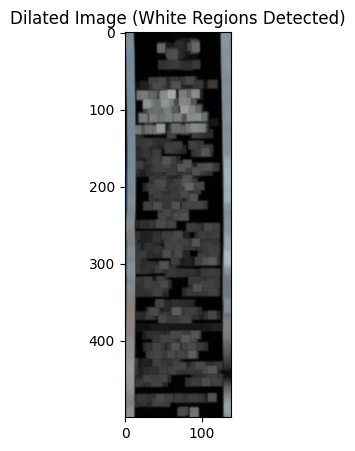

In [58]:
# Function to plot grayscale images
def plot_gray(image, title="Image"):
    plt.figure(figsize=(10,5))
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.show()

# Create a rectangular structuring element
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

# Apply dilation to enhance white regions
dilated = cv2.dilate(blurred, rectKernel)

# Display the result
plot_gray(dilated, "Dilated Image (White Regions Detected)")

In [59]:
# Assuming 'image' is already loaded and in grayscale
# Compute the blackhat transformation using a morphological closing
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))  # Define the structuring element (kernel)
closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)  # Perform the closing operation
blackhat = closing - image  # Compute the blackhat transform

# Now you can apply the Sobel operator
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)  # Take the absolute value
(minVal, maxVal) = (np.min(gradX), np.max(gradX))  # Normalize values


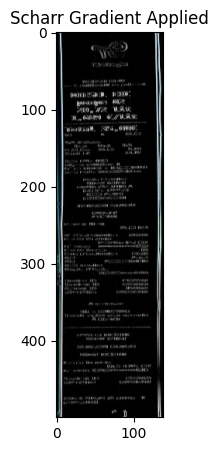

In [60]:
# Compute the Scharr gradient representation of the blackhat image
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)  # Take the absolute value
(minVal, maxVal) = (np.min(gradX), np.max(gradX))  # Normalize values
gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")

# Show the result
plot_gray(gradX, "Scharr Gradient Applied")


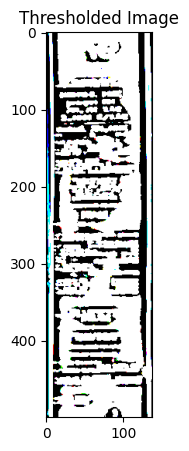

In [61]:
# Blur the gradient image
blurred = cv2.GaussianBlur(gradX, (5, 5), 0)

# Apply adaptive thresholding
T = threshold_local(blurred, block_size=35, offset=10, method="gaussian")
binary = (blurred > T).astype("uint8") * 255

# Show the result
plot_gray(binary, "Thresholded Image")


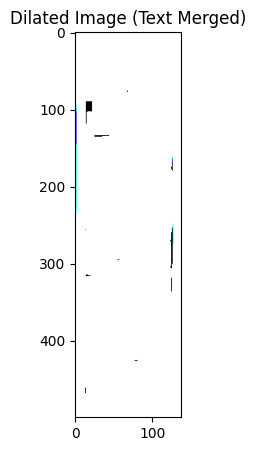

In [62]:
# Use dilation to connect text regions
dilated = cv2.dilate(binary, rectKernel)

# Show the result
plot_gray(dilated, "Dilated Image (Text Merged)")


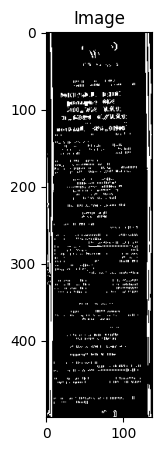

In [63]:
# Convert gradient image to grayscale if needed
if len(gradX.shape) == 3:
    gradX = cv2.cvtColor(gradX, cv2.COLOR_BGR2GRAY)

# Normalize the gradient image
gradX = (gradX - gradX.min()) / (gradX.max() - gradX.min())  # Normalize between 0 and 1
gradX = (gradX * 255).astype("uint8")  # Convert to 8-bit grayscale

# Apply Otsu's thresholding
_, thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Display the thresholded image
plot_gray(thresh)


In [64]:
def opencv_resize(image, ratio):
    """ Resize an image by a given ratio while keeping aspect ratio. """
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)


In [65]:
import matplotlib.pyplot as plt
import cv2

def plot_rgb(image):
    """Display an image in RGB format using Matplotlib."""
    plt.figure(figsize=(16, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")  # Hide axes for better visualization
    plt.show()


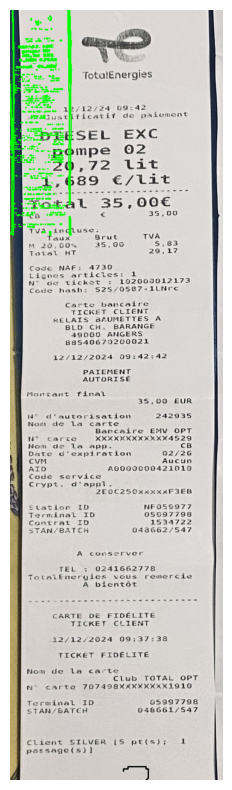

In [66]:
# Ensure the image is loaded correctly
file_name = r'C:\Users\gilles\project02\data project 05\Receipt02.png'  # Update with your file path
image = cv2.imread(file_name)

# Check if the image was loaded successfully
if image is None:
    raise ValueError("Error: Unable to load image. Check the file path!")

# Store a copy of the original image
original = image.copy()

# Downscale the image (if needed for better processing)
resize_ratio = 500 / original.shape[0]
image = opencv_resize(original, resize_ratio)  # Make sure opencv_resize is defined

# Now continue with contour detection
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
contour_img = original.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

# Display the result
plot_rgb(contour_img)


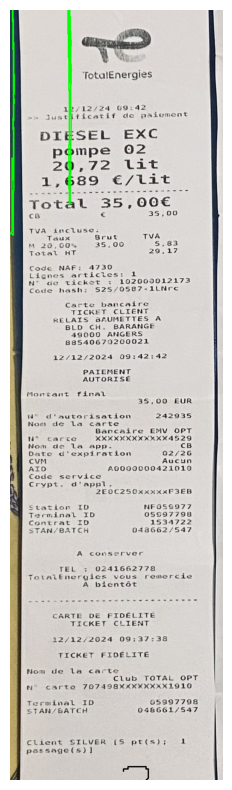

In [67]:
def sort_contours(cnts):
    """Sort contours from top to bottom."""
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]
    return zip(*sorted(zip(cnts, bounding_boxes), key=lambda b: b[1][1]))

# Sort contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours, _ = sort_contours(contours)

# Filter small contours
min_area = 500  # Adjust based on your image
filtered_contours = [c for c in sorted_contours if cv2.contourArea(c) > min_area]

# Draw filtered contours on a copy of the original image
contour_img = original.copy()
cv2.drawContours(contour_img, filtered_contours, -1, (0, 255, 0), 2)

# Display the result
plot_rgb(contour_img)


Extract Bounding Boxes Around Text

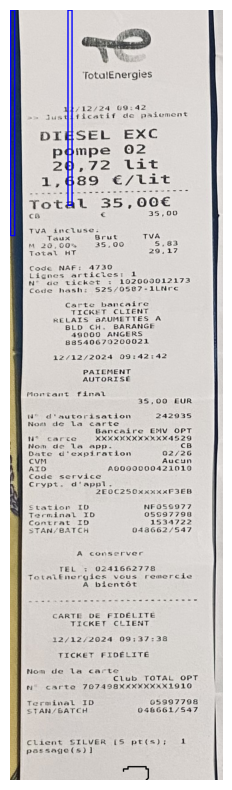

In [68]:
bounding_boxes = [cv2.boundingRect(c) for c in filtered_contours]

# Draw bounding boxes on the receipt
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(original, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display the bounding boxes
plot_rgb(original)


Crop Text Regions for OCR

In [69]:
text_regions = []
for (x, y, w, h) in bounding_boxes:
    roi = original[y:y+h, x:x+w]  # Crop the text region
    text_regions.append(roi)

    # Optional: Display each extracted text region
    plt.figure()
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


Apply OCR (Using Tesseract)

In [70]:
import pytesseract

for i, roi in enumerate(text_regions):
    text = pytesseract.image_to_string(roi, config='--psm 6')
    print(f"Text Region {i+1}:")
    print(text)
    print("-" * 50)


Text Region 1:

--------------------------------------------------
Text Region 2:

--------------------------------------------------
